In [27]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode

In [5]:
# Your code goes here
df = pd.read_csv('data/0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='m')

In [13]:
df = df.head(500)

In [14]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 'timestamp', 'value', freq='T')
# Set aside the last 36 months as a validation series
train, val = series[:-round(len(df) / 5)], series[-round(len(df) / 5):]

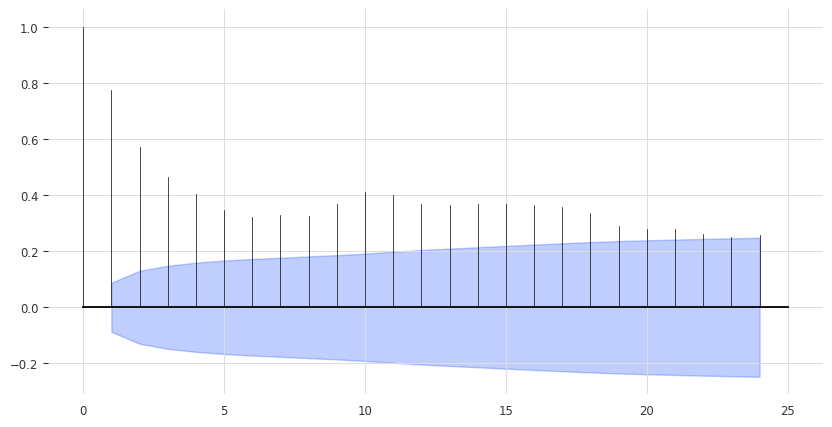

In [19]:
darts.utils.statistics.plot_acf(series)

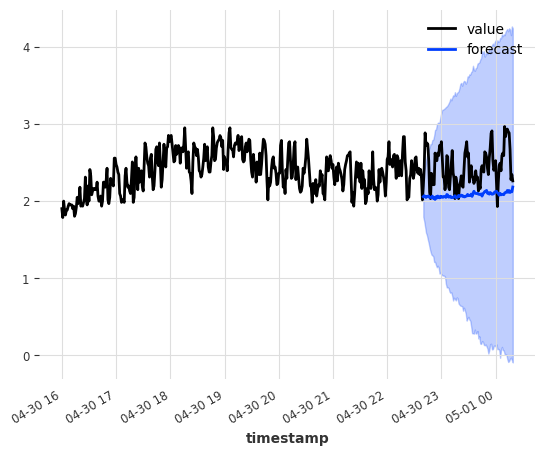

In [29]:
model = ExponentialSmoothing(seasonal=SeasonalityMode.NONE)
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)
# Plotting the predictions
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()